In [1]:
#https://moonbooks.org/Articles/How-to-create-a-table-of-contents-in-a-jupyter-notebook-/

# Indhold i EDA notebook

1. [Indlæs data og intro](#chapter1)
2. [Visualisering af kategorier](#chapter2)
3. [Timeseries](#chapter3)
4. [Geografisk Visualisering](#chapter4)
5. [Correlations](#chapter5)


# 1. Indlæs data og intro <a class="anchor" id="chapter1"></a>

In [2]:
# Generel Databehandling
import numpy as np
import pandas as pd

# Vizulatations:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = pd.read_csv('cleaned_df.csv', sep=';')
df_org = df.copy()

df.shape

(35433, 24)

In [19]:
df.head(2)

,titel,adresse,postnr,oprettelsesdato,oprettelsesdag,oprettelsesmåned,depositum,boligtype,etage,møbleret,...,månedlig_leje,aconto,status,image_count,antal_værelser,kvadratmeter,månedlig_leje_kvadratmeter,navn,Longitude,Latitude
0,5 værelses lejlighed på 115 m²,"Thit Jensens Gade, 8000 Aarhus C - 7. sal",8000,2019-11-01,Friday,November,46500,Lejlighed,7. sal,Nej,...,15500,290,Udlejet,9,5,115,134.78,Aarhus C,10.278021,56.150515
1,4 værelses lejlighed på 96 m²,"Dirch Passers Gade, 8000 Aarhus C - 5. sal",8000,2019-11-01,Friday,November,38280,Lejlighed,5. sal,Nej,...,12760,600,Udlejet,21,4,96,132.92,Aarhus C,10.278021,56.150515


In [5]:
df[['depositum', 'månedlig_leje', 'aconto', 'image_count', 'antal_værelser', 'kvadratmeter', 'månedlig_leje_kvadratmeter']].describe()

,depositum,månedlig_leje,aconto,image_count,antal_værelser,kvadratmeter,månedlig_leje_kvadratmeter
count,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000
mean,22579.747862,7922.146699,574.116248,8.337059,2.752942,82.434454,112.151195
std,13119.304936,4147.465462,520.819047,6.510520,1.201800,40.311782,93.520415
min,0.000000,1309.000000,0.000000,0.000000,1.000000,1.000000,9.090000
25%,13600.000000,4999.000000,0.000000,4.000000,2.000000,59.000000,73.150000
50%,20400.000000,6999.000000,600.000000,7.000000,3.000000,80.000000,92.390000
75%,29085.000000,9800.000000,850.000000,12.000000,4.000000,104.000000,129.310000
max,139500.000000,46500.000000,12500.000000,72.000000,16.000000,1100.000000,11400.000000


In [6]:
# Visulisere Kategori-cols (Husdyr, delevenlig, boligtype osv.)
# Yderligere Outlier-kontrol? (Min og Max per boligtype osv.)
# Ugedage/måned med flest oprettelser
# Timeseries med antal oprettelser per dag
# Timeseries med total/avg på månedlig_leje ?

# Fordelinger per område/postnr.

# Corr

# Lav nye cols undervejs, hvor det giver mening

# 2. Visualisering af kategorier <a class="anchor" id="chapter2"></a>

In [28]:
df_valuecounts_boligtyper = df['boligtype'].value_counts().reset_index().rename(columns={'index':'boligtype', 'boligtype':'antal'})
print(df_valuecounts_boligtyper)
fig_boligtyper = px.pie(df_valuecounts_boligtyper, values='antal', names='boligtype', title='Fordeling af boligtyper', 
                       width=600, height=400)
fig_boligtyper.show()

   boligtype  antal
0  Lejlighed  26732
1   Rækkehus   2945
2    Værelse   2925
3      Villa   2831


Her ses at størtedelen (75%) af dataen er fra boligtypen "Lejlighed". Det vil selvfølgelig påvirke det videre analyser. jeg kunne forsøge at normalisere dataen, så jeg nemmere kunne sammenligne mellem boligtyperne. 
Det har jeg valgt ikke at gøre her - men skal være opmærksom på, at 75% af alt dataen er Lejligheder.

In [30]:
def make_cat_plot(slt_category_x, slt_facet_col='boligtype'):
    df_cat_plot = df.groupby([slt_facet_col, slt_category_x], as_index=False).count().rename(columns={'adresse':'Antal'})
    fig_cat = px.bar(df_cat_plot, x=slt_category_x, y='Antal', title=f'Countplot per boligtype ({slt_category_x})' , facet_col=slt_facet_col, facet_col_wrap=4)
    return fig_cat.show()

cat_plot_list = ['antal_værelser', 'møbleret', 'husdyr', 'status', 'lejeperiode']

for i in cat_plot_list:
    make_cat_plot(i)

# 3. Timeseries <a class="anchor" id="chapter3"></a>
Laver en ny funktion der kan illustrere summen af månedlig_leje og antal oprettede boliger per oprettelsesdato

### 3.1 - Kummuleret månedlig_leje (dkk)

In [80]:
def make_timeseries_plot(slt_calculation, slt_column):
    
    if slt_calculation == 'Sum':   
        df_timeseries_1 = df.groupby(['oprettelsesdato'], as_index=False)[slt_column].sum()
        df_timeseries_2 = df.groupby(['oprettelsesdato', 'boligtype'], as_index=False)[slt_column].sum()
        titel = f'{slt_calculation} of {slt_column} (dkk) per oprettelsesdato'

        
    elif slt_calculation == 'Count':   
        df_timeseries_1 = df.groupby(['oprettelsesdato'], as_index=False)[slt_column].count()
        df_timeseries_2 = df.groupby(['oprettelsesdato', 'boligtype'], as_index=False)[slt_column].count()
        titel = f'{slt_calculation} of created entities per oprettelsesdato'
        
    else:
        return "Available options for 'slt_calculation' are Sum & Count"



    fig_timeseries_1 = px.line(df_timeseries_1, x='oprettelsesdato', y=slt_column, 
                               title='Total ' + titel)
    fig_timeseries_1.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=2, label="2m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig_timeseries_2 = px.line(df_timeseries_2, x='oprettelsesdato', y=slt_column, 
                               title=titel + ' (Per boligtype)', facet_col="boligtype", facet_col_wrap=2)

    return fig_timeseries_1.show(), fig_timeseries_2.show()

In [81]:
make_timeseries_plot('Sum', 'månedlig_leje')
make_timeseries_plot('Count', 'titel')

(None, None)

Det virker til at alle boligtyperne har nogle gennemgående udsving. Det tyder på nogle bestemte ugedage - så det vil jeg undersøger herunder:

In [110]:
df_weekday_bar = df.groupby(['oprettelsesdag', 'boligtype'], as_index=False)['månedlig_leje'].sum()

fig_weekday_bar = px.bar(df_weekday_bar, x="oprettelsesdag", y="månedlig_leje", color="boligtype", 
            hover_data=['månedlig_leje'], barmode = 'stack', title="Sum of månedlig_leje per weekday")
fig_weekday_bar.update_layout(xaxis=
                              {'categoryarray':['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']})
fig_weekday_bar.show()

Jeg vil gentage det ovenstående med måneder 

*OBS: Vær opmærksom på at jeg ikke har scrapet hele februar, hvilket gør sammenligningsgrundlaget herunder svagt.*

In [109]:
for i in df['oprettelsesmåned'].unique():
    
    min_val = pd.to_datetime(df[df['oprettelsesmåned'] == i]['oprettelsesdato'].min())
    max_val = pd.to_datetime(df[df['oprettelsesmåned'] == i]['oprettelsesdato'].max())
    min_val_str = min_val.strftime('%d-%m-%Y')
    max_val_str = max_val.strftime('%d-%m-%Y')
    
    print(f'{i}:')
    print('Første dato: ' + min_val_str)
    print('Sidste dato: ' + max_val_str)
    print('Total antal dage: ' + str(max_val - min_val)[:7] + '\n')

November:
Første dato: 01-11-2019
Sidste dato: 30-11-2019
Total antal dage: 29 days

December:
Første dato: 01-12-2019
Sidste dato: 31-12-2019
Total antal dage: 30 days

January:
Første dato: 01-01-2020
Sidste dato: 31-01-2020
Total antal dage: 30 days

February:
Første dato: 01-02-2020
Sidste dato: 07-02-2020
Total antal dage: 6 days 



In [84]:
df_month_bar = df.groupby(['oprettelsesmåned', 'boligtype'], as_index=False)['månedlig_leje'].sum()

fig_month_bar = px.bar(df_month_bar, x="oprettelsesmåned", y="månedlig_leje", color="boligtype", 
            hover_data=['månedlig_leje'], barmode = 'stack', title="Sum of månedlig_leje per oprettelsesmåned")
fig_month_bar.update_layout(xaxis=
                            {'categoryarray':['November','December','January','February']})
fig_month_bar.show()

# 4. Geografisk visualisering <a class="anchor" id="chapter4"></a>

In [12]:
for i in df['boligtype'].unique():
    temp_df = df[df['boligtype'] == i]
    temp_df_con = pd.concat([temp_df['navn'].value_counts()[:3], 
           temp_df['navn'].value_counts(normalize=True)[:3] * 100], 
          axis=1, keys=('Antal', 'Procent'), sort=False)
    print(i + ':')
    print(temp_df_con)
    print()

Lejlighed:
             Antal   Procent
Aalborg       2293  8.577735
Aarhus C      1593  5.959150
København S   1371  5.128685

Villa:
             Antal   Procent
Svenstrup J    174  6.146238
Vejle           86  3.037796
Viborg          47  1.660191

Rækkehus:
           Antal    Procent
Silkeborg    418  14.193548
Herning      132   4.482173
Vejle        123   4.176570

Værelse:
             Antal    Procent
Aarhus C       313  10.700855
København S    197   6.735043
Odense C       161   5.504274



In [13]:
df_villa_svenstrupj = df[(df['boligtype'] == 'Villa') & (df['navn'] == 'Svenstrup J')]['adresse']
print(f'Adresse for villaer i Svenstrup J: (ialt: {df_villa_svenstrupj.shape[0]} villaer)')
df_villa_svenstrupj.value_counts()

Adresse for villaer i Svenstrup J: (ialt: 174 villaer)


Toftegårdsvej, 9230 Svenstrup J           96
Carl Scharnbergs Vej, 9230 Svenstrup J    27
Valhal, 9230 Svenstrup J                  15
Hovedgaden, 9230 Svenstrup J              13
Svanelundsbakken, 9230 Svenstrup J         3
Ålborgvej, 9230 Svenstrup J                2
Skråvej, 9230 Svenstrup J                  2
Skovmærkevej, 9230 Svenstrup J             2
Stygge Krumpens Vej, 9230 Svenstrup J      2
Godthåbsvej, 9230 Svenstrup J              1
Klerkegade, 9230 Svenstrup J               1
Bredgade, 9230 Svenstrup J                 1
Gåsevej, 9230 Svenstrup J                  1
Munkegade, 9230 Svenstrup J                1
Hobrovej, 9230 Svenstrup J                 1
Hedeageren, 9230 Svenstrup J               1
Offerlunden, 9230 Svenstrup J              1
Ingstrupvej, 9230 Svenstrup J              1
Hedevangen, 9230 Svenstrup J               1
Bag Diget, 9230 Svenstrup J                1
Østergade, 9230 Svenstrup J                1
Name: adresse, dtype: int64

### Fordeling af boligtyper i landet

In [77]:
mapbox_access_token = 'pk.eyJ1IjoibWFkc2pjIiwiYSI6ImNrZWN3YzF6bjAwcDUyc3Q1OWc1amJhaDEifQ.MTO6xHwzu-9FJopzujIHlw'
px.set_mapbox_access_token(mapbox_access_token)

df_map = df.copy()
df_map['navn'] = df_map['navn'].apply(lambda x: x.split(' ')[0])

df_map = df.groupby(['navn', 'boligtype'], as_index=False).agg({'Latitude':'mean', 'Longitude':'mean', 'adresse':'count'})
df_map = df_map.rename(columns={'adresse':'Antal'})

fig_mapbox = px.scatter_mapbox(df_map, lat="Latitude", lon="Longitude",
                          color="boligtype", size='Antal', 
                          color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=5.3)
fig_mapbox.update_layout(
    mapbox = {
        'style': "outdoors"})

fig_mapbox.show()

*OBS: De fundne Longitude og Langtitude-værdier har ikke været så præcise som ønsket. Zoomes der ind på Nordjylland kan der ses flere boliger i Skagerrak*

# 5. Correlations <a class="anchor" id="chapter5"></a>
For at få en hurtig ide om Correlations i columns, laver jeg nedenstående heatmap

Text(0.5, 1, 'Alle boligtyper samlet')

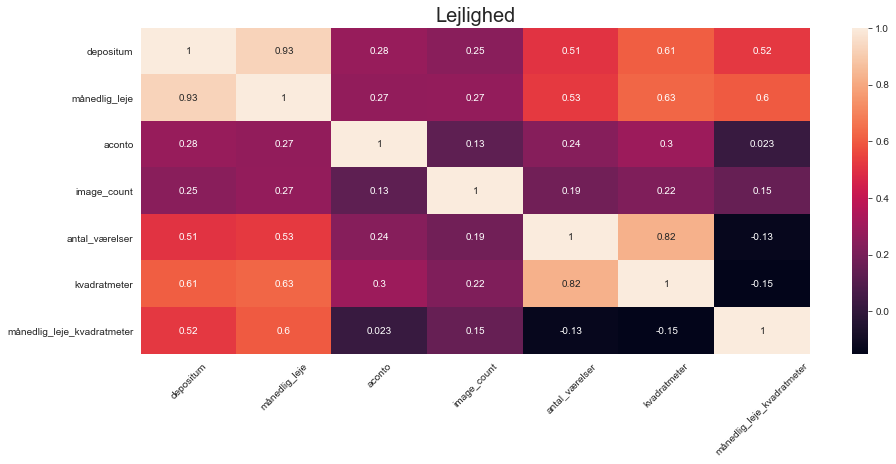

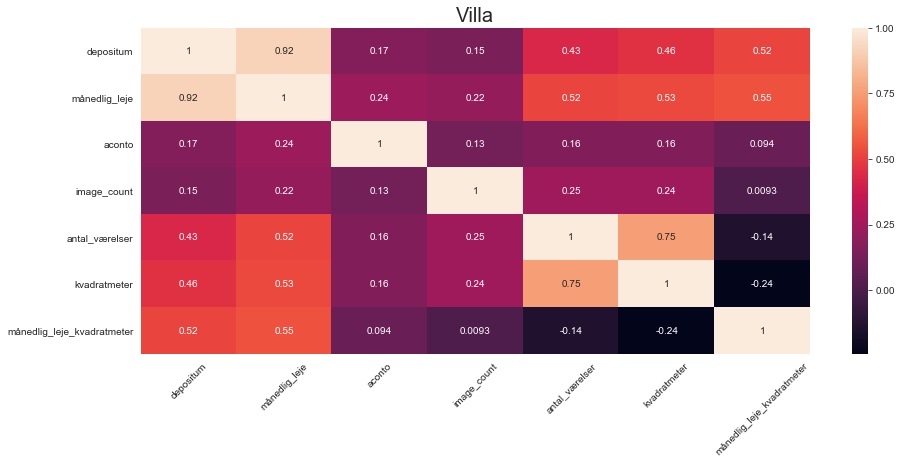

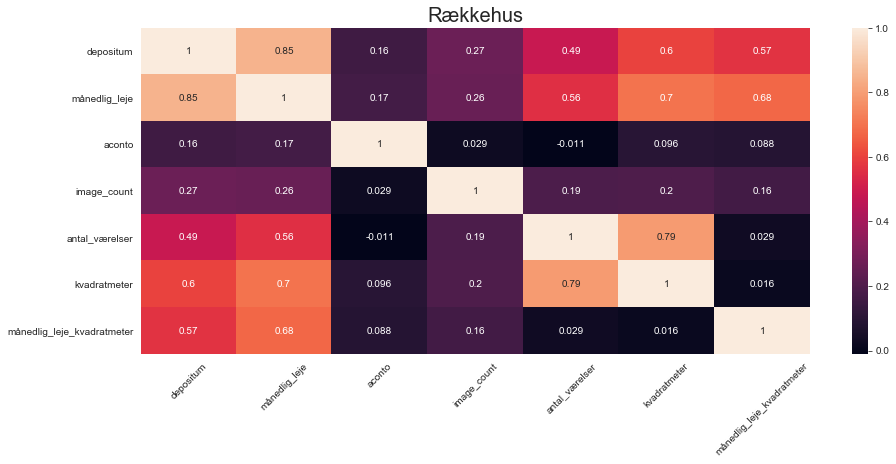

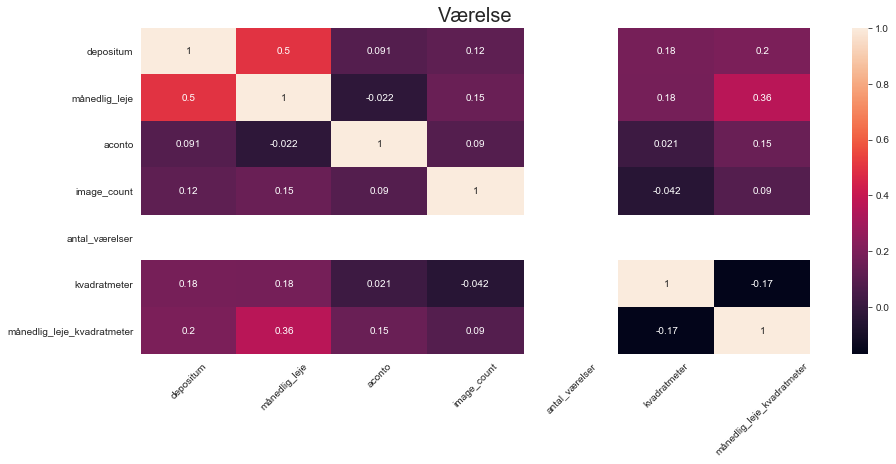

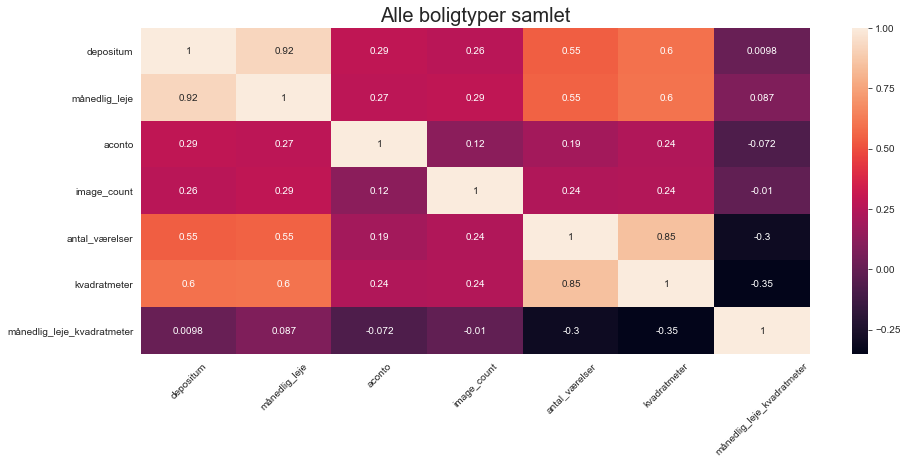

In [15]:
corr_columns_of_interest = ['oprettelsesdato', 'oprettelsesdag',
       'oprettelsesmåned', 'depositum', 'boligtype', 'etage', 'møbleret',
       'delevenlig', 'husdyr', 'lejeperiode', 'overtagelsesdato',
       'månedlig_leje', 'aconto', 'status', 'image_count', 'antal_værelser',
       'kvadratmeter', 'månedlig_leje_kvadratmeter']


#For hver boligtype
for i in df['boligtype'].unique():
    fig, ax = plt.subplots(figsize=(15,6))
    sns.heatmap(df[df['boligtype'] == i][corr_columns_of_interest].corr(), annot=True, ax=ax)
    plt.xticks(rotation=45)
    plt.title(i, fontsize=20)

#Alle boligtyper samlet
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(df[corr_columns_of_interest].corr(), annot=True, ax=ax)
plt.xticks(rotation=45)
plt.title('Alle boligtyper samlet', fontsize=20)

In [115]:
def make_corr_JointGrid(slt_x, slt_y, slt_xlim, slt_ylim):
    corr_plot = sns.JointGrid(data=df, x=slt_x, y=slt_y, xlim=slt_xlim, ylim=slt_ylim, height=8, ratio=3)
    corr_plot.plot_joint(sns.regplot, x_jitter=.5)
    corr_plot.plot_marginals(sns.distplot, kde=True)

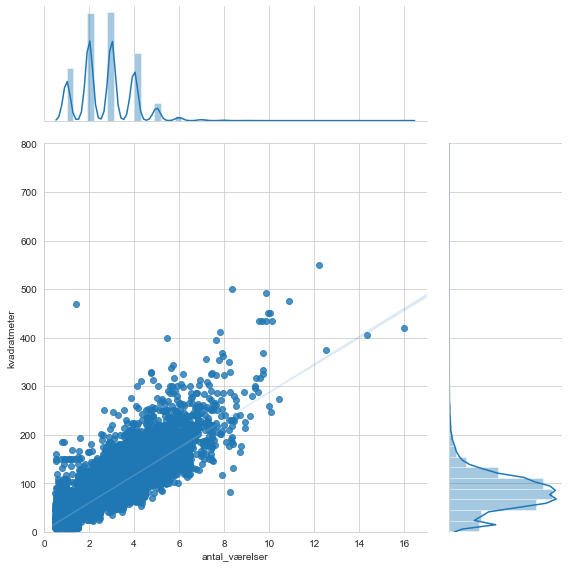

In [116]:
make_corr_JointGrid('antal_værelser', 'kvadratmeter', (0, 17), (0, 800))

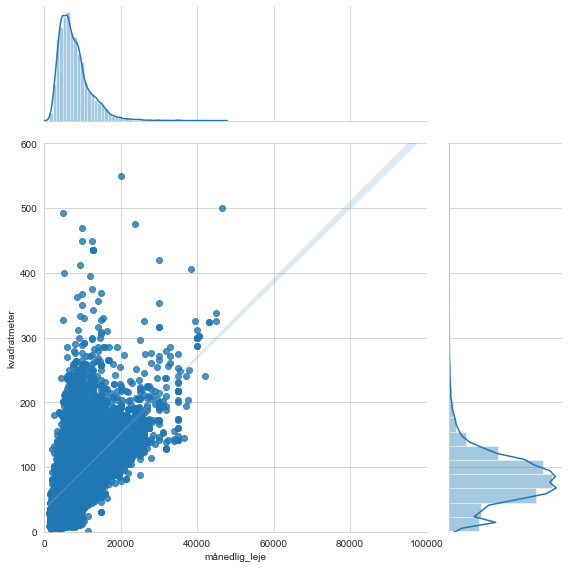

In [117]:
make_corr_JointGrid('månedlig_leje', 'kvadratmeter', (0, 100000), (0, 600))

In [35]:
df.describe()

,postnr,depositum,månedlig_leje,aconto,image_count,antal_værelser,kvadratmeter,månedlig_leje_kvadratmeter,Longitude,Latitude
count,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000,35433.000000
mean,6323.489120,22579.747862,7922.146699,574.116248,8.337059,2.752942,82.434454,112.151195,10.533784,55.993632
std,2558.851758,13119.304936,4147.465462,520.819047,6.510520,1.201800,40.311782,93.520415,1.293764,0.614269
min,1050.000000,0.000000,1309.000000,0.000000,0.000000,1.000000,1.000000,9.090000,4.074613,54.496085
25%,4200.000000,13600.000000,4999.000000,0.000000,4.000000,2.000000,59.000000,73.150000,9.619962,55.640036
50%,7100.000000,20400.000000,6999.000000,600.000000,7.000000,3.000000,80.000000,92.390000,10.159224,55.819820
75%,8600.000000,29085.000000,9800.000000,850.000000,12.000000,4.000000,104.000000,129.310000,11.905854,56.222240
max,9990.000000,139500.000000,46500.000000,12500.000000,72.000000,16.000000,1100.000000,11400.000000,15.393011,57.942812
